# Classic minimax GAN

In [1]:
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.utils import shuffle
import matplotlib
import random
import torch.autograd as autograd
from sklearn.model_selection import cross_val_score, KFold
import sklearn.metrics
import h5py
import torch.nn.functional as F
import pickle
import torch.distributions.multivariate_normal as mn
import math

import torch.autograd as autograd
from sklearn.preprocessing import StandardScaler

from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf

from sklearn.decomposition import PCA

random_seed = 99
torch.manual_seed(random_seed)
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else "cpu")
# DEVICE = torch.device('cpu')

In [2]:
pulses = pickle.load(open('/Users/nzaretski/Desktop/gerda/CNN_GAN_Ge/data/raw/data.pkl','rb'))
pulses = pulses.astype(float)

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pulses = scaler.fit_transform(pulses) #remove

In [4]:
train_data_length = pulses.shape[0]
train_data = torch.zeros((train_data_length, pulses.shape[1]))
train_data = torch.tensor(pulses, dtype=torch.float)
train_labels = torch.zeros(train_data_length, 1)

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [5]:
batch_size = 128

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

## 1. Models

In [7]:
#epochs = 500
lr = 1e-4
#autoenc
seq_len = 5000

random_dim = 32 


In [8]:
class Discriminator(nn.Module):   ## changed
    def __init__(self):
        super(Discriminator, self).__init__()
        self.seq_len = seq_len
        self.model = nn.Sequential(            
            nn.Conv1d(self.seq_len, self.seq_len // 4, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 4, self.seq_len // 16, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 16, self.seq_len // 64, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(self.seq_len // 64, self.seq_len // 256, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 256, 1, 1, bias=False),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return torch.sigmoid(output.squeeze(-1))

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.seq_len = seq_len
        self.latent_dims = random_dim
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.latent_dims, self.seq_len // 64, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 64),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 64, self.seq_len // 16, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 16),
            nn.ReLU(True),
            
            nn.ConvTranspose1d(self.seq_len // 16, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.ReLU(True),
            
            nn.ConvTranspose1d(self.seq_len // 4, self.seq_len, 1, bias=False)
      )


    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        return output.squeeze(-1)

#  Minimax

In [10]:
netD = Discriminator().to(DEVICE)
netG = Generator().to(DEVICE)
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)

In [11]:
epochs = 100

In [12]:
#autoenc
EPS = 1e-15
one = torch.FloatTensor([1])
mone = one * -1
one = one.to(DEVICE)
mone = mone.to(DEVICE)

G_losses = []
D_losses = []
import time
start_time = time.time()

for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        x = x.to(DEVICE)
        real_samples_labels = torch.ones((batch_size, 1))
        real_samples_labels = real_samples_labels.to(DEVICE)
        
        latent_space_samples = torch.randn((batch_size, random_dim))
        latent_space_samples = latent_space_samples.to(DEVICE)
        
        generated_samples = netG(latent_space_samples)
        
        generated_samples_labels = torch.zeros((batch_size, 1))
        generated_samples_labels = generated_samples_labels.to(DEVICE)
        
        all_samples = torch.cat((x, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        ## training the discriminator
        netD.zero_grad()
        output_discriminator = netD(all_samples)
        
        errD = criterion(output_discriminator, all_samples_labels)
        errD.backward()
        optimizerD.step()
        
        ## training the generator
        latent_space_samples = torch.randn(batch_size, random_dim)
        latent_space_samples = latent_space_samples.to(DEVICE)
        netG.zero_grad()
        generated_samples = netG(latent_space_samples)
        outputDG = netD(generated_samples)
        errG = criterion(outputDG, real_samples_labels) #########
        errG.backward()
        optimizerG.step()
        
        G_losses.append(errG.item()) 
        D_losses.append(errD.item())
    
        
        if (epoch % 50 == 0 and i == batch_size - 1):
                print(f"Epoch{epoch} Loss D.: {errD}" "||" 
                  f"Loss G.: {errG}")
                
    if (epoch == 0):
        print(round(time.time() - start_time, 2), ' seconds')
    
    if (epoch % 50 == 0):
        torch.save(netG.state_dict(), 'gen' +str(epoch) + '.pth')
        torch.save(netD.state_dict(), 'discr' +str(epoch) + '.pth')   
        

6.2  seconds


In [13]:
torch.save(netG.state_dict(), 'minimax.pth')

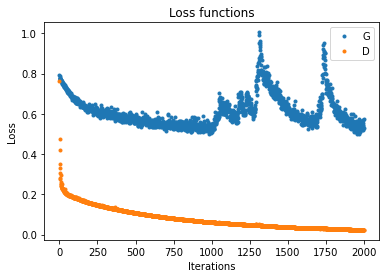

In [14]:
fig = plt.figure()
plt.plot(G_losses, '.', label='G')
plt.plot(D_losses, '.',  label='D')
plt.title('Loss functions')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
fig.savefig('losses.png')

# Check

In [15]:
netG = Generator() 
netG.load_state_dict(torch.load("minimax.pth"))

<All keys matched successfully>

In [16]:
x = torch.randn(10, random_dim)

In [17]:
gen = netG(x).cpu().detach()
#gen = pca.inverse_transform(gen) # back to 3748
gen = scaler.inverse_transform(gen) # back to normal

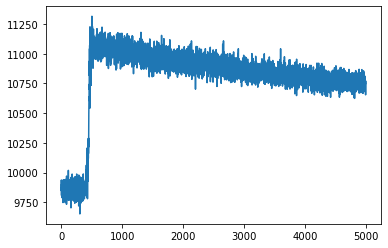

In [18]:
plt.plot(gen[0])

In [ ]:
# bad shape!